In [4]:
import nltk
import pandas as pd
import numpy as np
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
import glob
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import cross_val_predict
import matplotlib.pylab as plt
%matplotlib inline
import statsmodels.api as sm
import statsmodels.tsa.api as smt 
from statsmodels.tsa.stattools import adfuller
import math
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# kantar

In [208]:
# read in kantar
k_15 = pd.read_excel("kantar.xlsx",
                     header = 4, sheet_name = '2015')
k_16 = pd.read_excel("kantar.xlsx",
                     header = 4, sheet_name = '2016')
k_17 = pd.read_excel("kantar.xlsx",
                     header = 4, sheet_name = '2017')

In [207]:
def kantar_cleaning_weekly(kantar, level):
   # get only the relevant rows
   last_ind = np.where(kantar.PARENT == 'Xerox Corp TOTAL')[0][0] + 1
   kantar = kantar[:last_ind]
   
   # create dates and melt dataframe to get date values in one column
   dates = [i for i in kantar.columns.tolist() if 'DOLS' in i]
   dates.remove('TOTAL DOLS (000)')
   k_cols = ['PARENT', 'SUBSIDIARY', 'ADVERTISER', 'PRODUCT','MEDIA']
   
   kantar_melt = pd.melt(kantar, id_vars=k_cols, value_vars=dates)
   kantar_melt.rename(columns = {'variable': 'week', 'value': 'dollars'}, inplace = True)

   # transform to datetime
   kantar_melt.week = [pd.to_datetime(i.split((' (B)'))[0][3:], format = '%m/%d/%y') for i in kantar_melt.week]
   
   # fillna with 0 (0 dollars spent)
   kantar_melt.dollars = kantar_melt.dollars.fillna(0.0)
   
   # reshape dataframe to have each row to be 1 week
   k_cols.remove(level)
   k_cols.remove('MEDIA')
   
   kantar_melt.drop(k_cols, inplace = True, axis = 1)
   kantar_melt['ADTYPE'] = kantar_melt[level] + '_' + kantar_melt.MEDIA
   kantar_melt.drop([level, 'MEDIA'], inplace = True, axis = 1)
   kantar_melt_weekly = kantar_melt.pivot_table(index='week',
                                columns='ADTYPE',
                                values='dollars')
   
   return kantar_melt_weekly

In [209]:
# cleaning each sheet and concatenating data
# clean kantar
k_15_clean = kantar_cleaning_weekly(k_15, 'SUBSIDIARY')
k_16_clean = kantar_cleaning_weekly(k_16, 'SUBSIDIARY')
k_17_clean = kantar_cleaning_weekly(k_17, 'SUBSIDIARY')

# final kantar concat
kantar_all = pd.concat([k_15_clean, k_16_clean, k_17_clean])

In [212]:
kantar_clean = pd.read_csv('~/Documents/Programming/i-com/kantar_cleaned_weekly.csv')

In [61]:
kantar = pd.read_csv('~/Documents/Programming/i-com/kantar_cleaned_weekly_p.csv')

In [62]:
kantar.head()

,week,Adobe Systems Inc_B-to-B,Adobe Systems Inc_Cable TV,Adobe Systems Inc_Int Display,Adobe Systems Inc_Int Search,Adobe Systems Inc_Local Radio,Adobe Systems Inc_Mobile Web,Adobe Systems Inc_Natl Newsp,Adobe Systems Inc_Network TV,Adobe Systems Inc_Online Video,...,Xerox Corp_Local Radio,Xerox Corp_Magazines,Xerox Corp_Mobile Web,Xerox Corp_Natl Newsp,Xerox Corp_Natl Spot Radio,Xerox Corp_Network TV,Xerox Corp_Newspapers,Xerox Corp_Online Video,Xerox Corp_Outdoor,Xerox Corp_Spot TV
0,2014-12-29,0.0,0.0,1.486486,20.6750,NaN,0.0,0.0,0.0,0.00,...,0.12,0.0,0.0,0.0,0.133333,0.0,0.0000,0.0,0.0,0.0
1,2015-01-05,0.0,0.0,2.020270,20.7125,NaN,0.0,0.0,0.0,0.00,...,0.12,0.0,0.0,0.0,0.166667,0.0,0.0000,0.0,0.0,0.0
2,2015-01-12,0.0,0.0,2.370270,20.7125,NaN,0.0,0.0,0.0,3.02,...,0.00,0.0,0.0,0.0,0.166667,0.0,0.0000,0.0,0.0,0.0
3,2015-01-19,0.0,0.0,0.833784,20.7125,NaN,0.0,0.0,0.0,9.84,...,0.02,0.0,0.0,0.0,0.166667,0.0,0.0000,0.0,0.0,0.0
4,2015-01-26,0.0,0.0,2.959459,21.6000,NaN,0.0,0.0,0.0,11.92,...,0.10,0.0,0.0,0.0,0.200000,0.0,0.0875,0.0,0.0,0.0


# Money spent varaible creation

We will now extract money spent on advertising by Intel and the 5 most correlated companies: 'Facebook Inc', 'Nvidia Corp', 'Twitter Inc', 'Alphabet Inc', 'Sap AG' and GE

## Intel

In [450]:
# find intel columns 
intel_cols = [col for col in kantar_clean.columns if 'Intel' in col]
print(intel_cols)

kantar_intel = kantar_clean[intel_cols]

['Intel Network Systems Inc_B-to-B', 'Intel Network Systems Inc_Cable TV', 'Intel Network Systems Inc_Cinema', 'Intel Network Systems Inc_Hispanic Mags', 'Intel Network Systems Inc_Hispanic Newsp', 'Intel Network Systems Inc_Int Display', 'Intel Network Systems Inc_Int Search', 'Intel Network Systems Inc_Local Radio', 'Intel Network Systems Inc_Magazines', 'Intel Network Systems Inc_Mobile Web', 'Intel Network Systems Inc_Natl Newsp', 'Intel Network Systems Inc_Natl Spot Radio', 'Intel Network Systems Inc_Network Radio', 'Intel Network Systems Inc_Network TV', 'Intel Network Systems Inc_Newspapers', 'Intel Network Systems Inc_Online Video', 'Intel Network Systems Inc_Outdoor', 'Intel Network Systems Inc_Spot TV', 'Intel Network Systems Inc_Syndication', 'Intel Semiconductor_B-to-B', 'Intel Semiconductor_Int Display', 'Intel Semiconductor_Mobile Web']


In [226]:
kantar_intel = kantar_intel.fillna(0.0)

In [227]:
# y-variable with the sum of spending
kantar_intel['sum'] = kantar_intel.sum(axis=1)

Let's predict spend with a time series model

In [264]:
y = kantar_intel['sum']

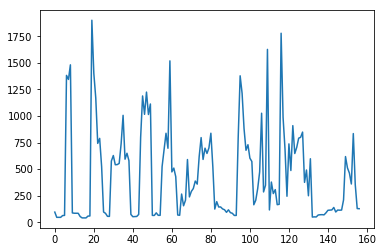

In [265]:
plt.plot(y)

In [266]:
#ADF Test

#H0: Series is not stationary
#H1: Series is stationary

dftest = adfuller(y, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

print(dfoutput)

Test Statistic                -6.424704e+00
p-value                        1.756226e-08
#Lags Used                     4.000000e+00
Number of Observations Used    1.520000e+02
dtype: float64


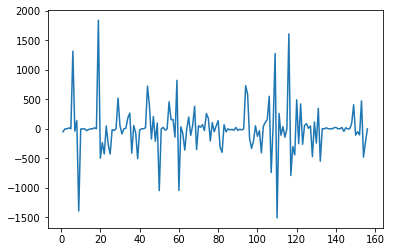

In [306]:
z = y.diff()

z.dropna(inplace=True)

plt.plot(z)

In [307]:
z.dropna(inplace=True)

In [349]:
dftestz = adfuller(z, autolag='AIC')
dfoutputz = pd.Series(dftestz[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

print(dfoutputz)

Test Statistic                -7.728767e+00
p-value                        1.140167e-11
#Lags Used                     9.000000e+00
Number of Observations Used    1.460000e+02
dtype: float64


ACF/PACF

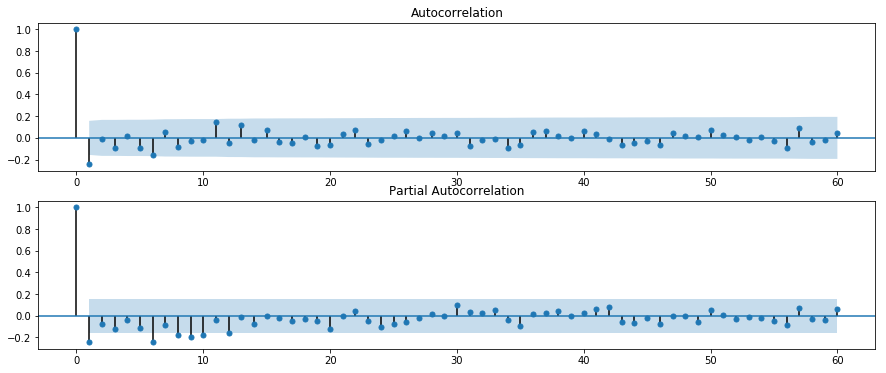

In [309]:
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(z, lags=60, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(z, lags=60, ax=ax2)
plt.show()

In [350]:
# Convert to array so that it can be read by the ARIMA function.
z1 = z.values
y1 = y.values

# using the series after a difference has been taken and using AR of order 6.
model=sm.tsa.ARIMA(y1,order=(10,2,0))
results=model.fit()
print(results.summary())

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                  155
Model:                ARIMA(10, 2, 0)   Log Likelihood               -1150.301
Method:                       css-mle   S.D. of innovations            400.593
Date:                Sat, 07 Apr 2018   AIC                           2324.602
Time:                        16:51:41   BIC                           2361.123
Sample:                             2   HQIC                          2339.436
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.3167      3.856     -0.082      0.935      -7.874       7.241
ar.L1.D2.y     -1.1140      0.077    -14.487      0.000      -1.265      -0.963
ar.L2.D2.y     -1.0294      0.113     -9.137    

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


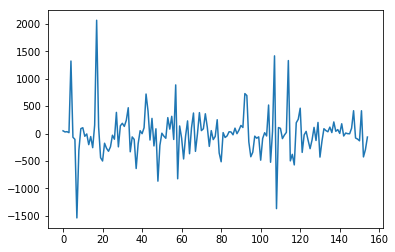

In [351]:
plt.plot(results.resid)

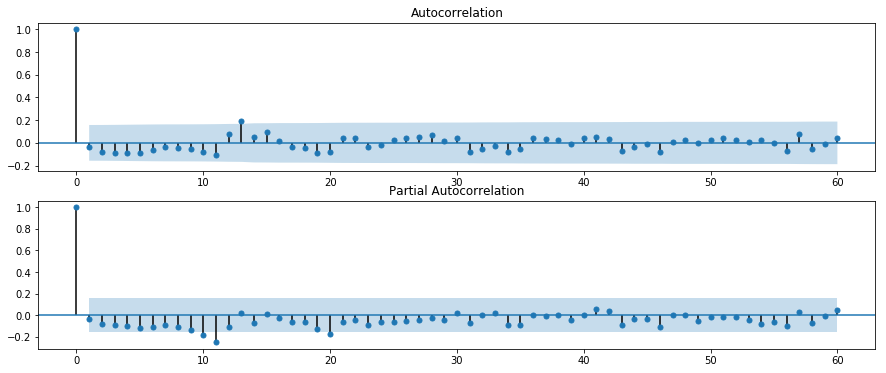

In [352]:
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(results.resid, lags=60, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(results.resid, lags=60, ax=ax2)
plt.show()

Prediction

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


predicted=203.804303, expected=618.159409
predicted=599.437378, expected=511.699766
predicted=568.971325, expected=462.898558
predicted=495.293083, expected=360.459890
predicted=417.038217, expected=834.277001
predicted=789.092871, expected=354.415453
predicted=430.339854, expected=129.447212
predicted=193.991932, expected=128.147019
Test MSE: 83340.507


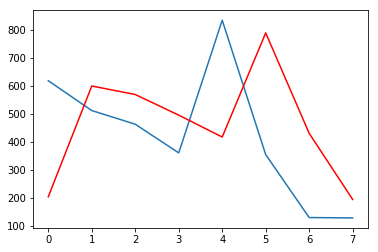

In [353]:
from sklearn.metrics import mean_squared_error

size = int(len(y1) * 0.95)
train, test = y1[0:size], y1[size:len(y1)]
history = [x for x in train]
predictions = list()

for t in range(len(test)):
    model = ARIMA(history, order=(10,2,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
    
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [354]:
intel_preds = results.predict(start=157, end=161, typ='levels')

print(intel_preds)

[161.5685489  169.31186407 168.53208205 314.1911355  221.88703851]


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


Add to data and forward fill

In [426]:
weeks = kantar_clean['week']
weeks = pd.DataFrame(weeks)

week_rng = pd.date_range(start = '2017-12-26', end = '2018-01-31', freq = 'W')
week_rng = pd.DataFrame(week_rng)

weeks = pd.concat([weeks['week'], week_rng], axis=0)
weeks = weeks.rename(index=str, columns={0:'week'})

weeks['week'] = pd.to_datetime(weeks.week, format='%Y-%m-%d') 

In [437]:
sum_intel = pd.DataFrame(y)
intel_preds = pd.DataFrame(intel_preds)

sum_intel = pd.concat([sum_intel['sum'], intel_preds], axis=0)
sum_intel = pd.DataFrame(sum_intel)
sum_intel = sum_intel.set_index(weeks['week'])

sum_intel = sum_intel.resample('D').ffill()

In [418]:
# sum_intel = sum_intel.rename(index=str, columns={'week':'week', 0:'sum'})

In [440]:
# sum_intel['week'] = pd.to_datetime(sum_intel.week, format='%Y-%m-%d') 
# sum_intel = sum_intel.resample('D').ffill()

In [442]:
sum_intel.to_csv('sum_intel.csv')

## Facebook

In [479]:
# find facebook columns 
facebook_cols = [col for col in kantar.columns if 'Facebook' in col]
print(facebook_cols)

kantar_facebook = kantar[facebook_cols]

['Facebook Inc_B-to-B', 'Facebook Inc_Cable TV', 'Facebook Inc_Cinema', 'Facebook Inc_Hispanic Mags', 'Facebook Inc_Int Display', 'Facebook Inc_Int Search', 'Facebook Inc_Local Mags', 'Facebook Inc_Local Radio', 'Facebook Inc_Mobile Web', 'Facebook Inc_Natl Newsp', 'Facebook Inc_Network TV', 'Facebook Inc_Newspapers', 'Facebook Inc_Online Video', 'Facebook Inc_Outdoor', 'Facebook Inc_Spot TV']


In [481]:
kantar_facebook = kantar_facebook.fillna(0.0)

kantar_facebook['sum'] = kantar_facebook.sum(axis=1)

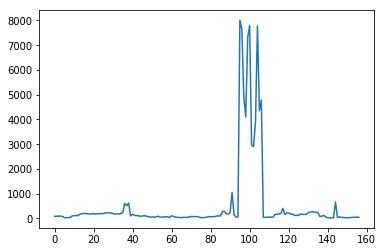

In [496]:
y = kantar_facebook['sum']

plt.plot(y)

In [497]:
# I will slice the data to avoid incorporating the massive outlier in my model
y = y[110:]

In [499]:
#ADF Test

#H0: Series is not stationary
#H1: Series is stationary

dftest = adfuller(y, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

print(dfoutput)

Test Statistic                 -5.094592
p-value                         0.000014
#Lags Used                      0.000000
Number of Observations Used    46.000000
dtype: float64


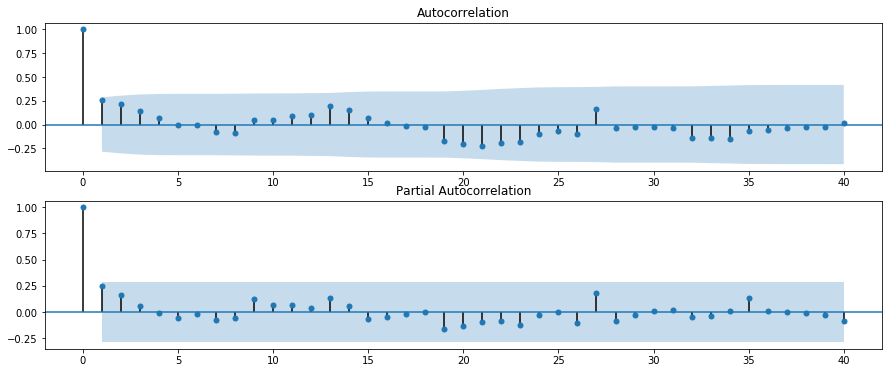

In [502]:
# ACF / PACF
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(y, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(y, lags=40, ax=ax2)
plt.show()

In [509]:
# stationary data with lags in bounds --> the best forecast is the mean



## Nvidia

In [510]:
# find columns 
nvidia_cols = [col for col in kantar.columns if 'Nvidia' in col]
print(nvidia_cols)

kantar_nvidia = kantar[nvidia_cols]

['Nvidia Corp_B-to-B', 'Nvidia Corp_Cable TV', 'Nvidia Corp_Int Display', 'Nvidia Corp_Int Search', 'Nvidia Corp_Local Radio', 'Nvidia Corp_Mobile Web', 'Nvidia Corp_Newspapers', 'Nvidia Corp_Online Video', 'Nvidia Corp_Outdoor']


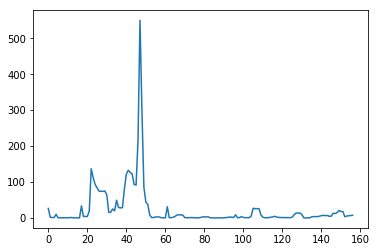

In [512]:
kantar_nvidia = kantar_nvidia.fillna(0.0)

kantar_nvidia['sum'] = kantar_nvidia.sum(axis=1)

y = kantar_nvidia['sum']

plt.plot(y)

In [513]:
#ADF Test

#H0: Series is not stationary
#H1: Series is stationary

dftest = adfuller(y, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

print(dfoutput)

Test Statistic                  -3.914204
p-value                          0.001933
#Lags Used                       2.000000
Number of Observations Used    154.000000
dtype: float64


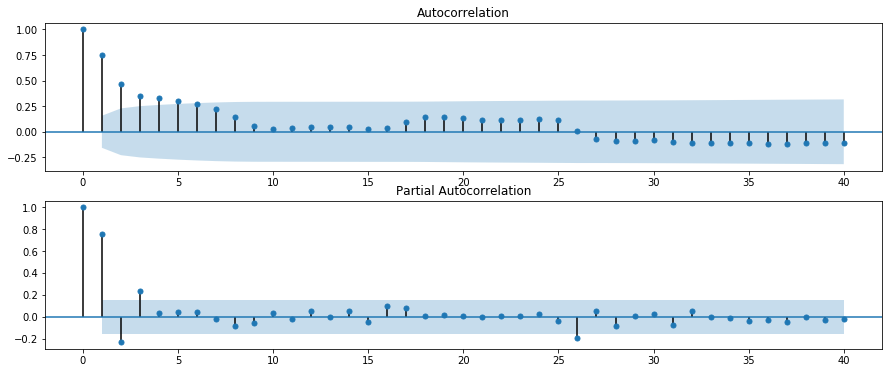

In [514]:
# ACF / PACF
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(y, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(y, lags=40, ax=ax2)
plt.show()

In [515]:
# Convert to array so that it can be read by the ARIMA function.
y1 = y.values

# using the series after a difference has been taken and using AR of order 6.
model=sm.tsa.ARIMA(y1,order=(5,0,0))
results=model.fit()
print(results.summary())

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  157
Model:                     ARMA(5, 0)   Log Likelihood                -788.170
Method:                       css-mle   S.D. of innovations             36.515
Date:                Sat, 07 Apr 2018   AIC                           1590.340
Time:                        18:12:34   BIC                           1611.734
Sample:                             0   HQIC                          1599.029
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         22.6687     12.862      1.762      0.080      -2.540      47.878
ar.L1.y        0.9677      0.080     12.166      0.000       0.812       1.124
ar.L2.y       -0.4418      0.111     -3.982      0.0

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


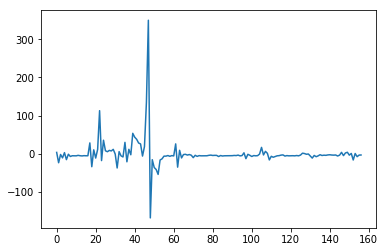

In [516]:
plt.plot(results.resid)

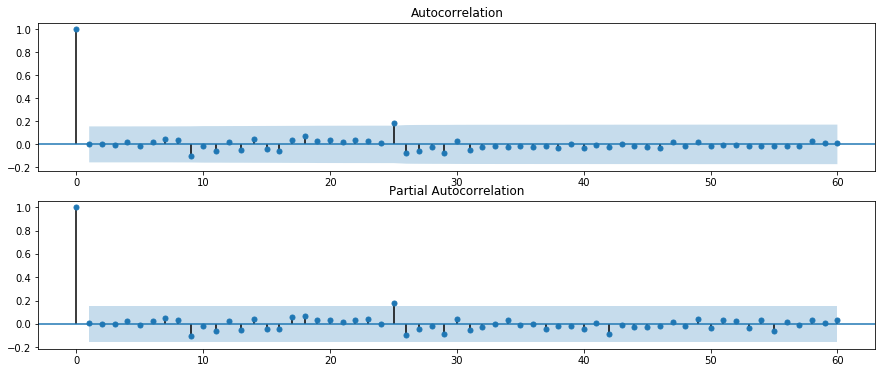

In [517]:
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(results.resid, lags=60, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(results.resid, lags=60, ax=ax2)
plt.show()

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


predicted=16.855680, expected=20.690179
predicted=21.600887, expected=17.895536
predicted=16.989999, expected=17.805357
predicted=19.463324, expected=3.125000
predicted=4.604425, expected=5.336607
predicted=13.521019, expected=5.962500
predicted=9.733580, expected=6.339286
predicted=10.439394, expected=7.332143
Test MSE: 46.860


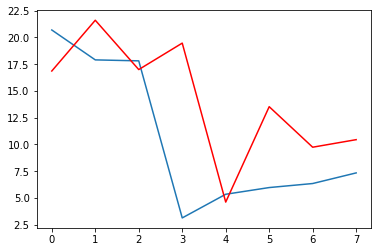

In [519]:
size = int(len(y1) * 0.95)
train, test = y1[0:size], y1[size:len(y1)]
history = [x for x in train]
predictions = list()

for t in range(len(test)):
    model = ARIMA(history, order=(5,0,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
    
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [521]:
nvidia_preds = results.predict(start=157, end=161)

print(nvidia_preds)

[10.69644603 13.68485691 15.33265288 16.35613007 17.28590011]


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


In [523]:
sum_nvidia = pd.DataFrame(y)
nvidia_preds = pd.DataFrame(nvidia_preds)

sum_nvidia = pd.concat([sum_nvidia['sum'], nvidia_preds], axis=0)
sum_nvidia = pd.DataFrame(sum_nvidia)
sum_nvidia = sum_nvidia.set_index(weeks['week'])


sum_nvidia = sum_nvidia.resample('D').ffill()

In [533]:
sum_nvidia.to_csv('sum_nvidia.csv')

## Twitter Inc

In [525]:
# find columns 
twitter_cols = [col for col in kantar.columns if 'Twitter' in col]
print(twitter_cols)

kantar_twitter = kantar[twitter_cols]

['Twitter Inc_B-to-B', 'Twitter Inc_Cable TV', 'Twitter Inc_Int Display', 'Twitter Inc_Int Search', 'Twitter Inc_Local Radio', 'Twitter Inc_Mobile Web', 'Twitter Inc_Network TV', 'Twitter Inc_Online Video', 'Twitter Inc_Outdoor', 'Twitter Inc_Spot TV']


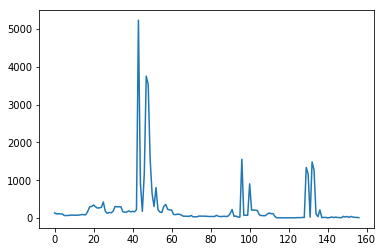

In [526]:
kantar_twitter = kantar_twitter.fillna(0.0)

kantar_twitter['sum'] = kantar_twitter.sum(axis=1)

y = kantar_twitter['sum']

plt.plot(y)

In [527]:
#ADF Test

#H0: Series is not stationary
#H1: Series is stationary

dftest = adfuller(y, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

print(dfoutput)

Test Statistic                  -3.194339
p-value                          0.020315
#Lags Used                       3.000000
Number of Observations Used    153.000000
dtype: float64


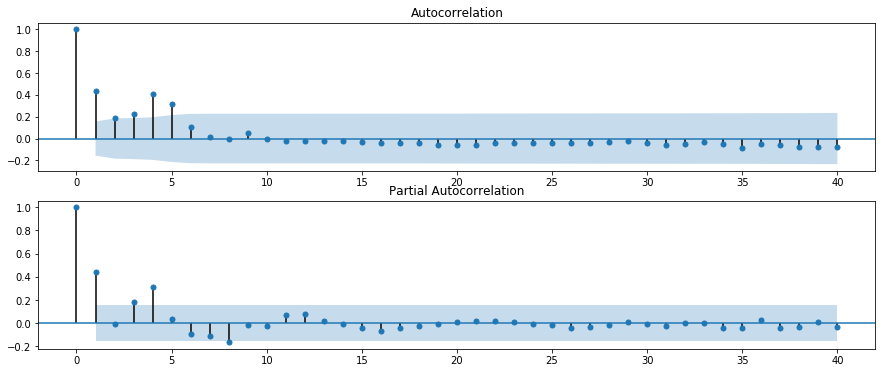

In [528]:
# ACF / PACF
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(y, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(y, lags=40, ax=ax2)
plt.show()

In [529]:
# Convert to array so that it can be read by the ARIMA function.
y1 = y.values

# using the series after a difference has been taken and using AR of order 6.
model=sm.tsa.ARIMA(y1,order=(5,0,0))
results=model.fit()
print(results.summary())

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  157
Model:                     ARMA(5, 0)   Log Likelihood               -1207.402
Method:                       css-mle   S.D. of innovations            528.099
Date:                Sat, 07 Apr 2018   AIC                           2428.804
Time:                        18:23:52   BIC                           2450.197
Sample:                             0   HQIC                          2437.492
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        243.1500    130.026      1.870      0.063     -11.696     497.996
ar.L1.y        0.3711      0.080      4.667      0.000       0.215       0.527
ar.L2.y       -0.0624      0.081     -0.771      0.4

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


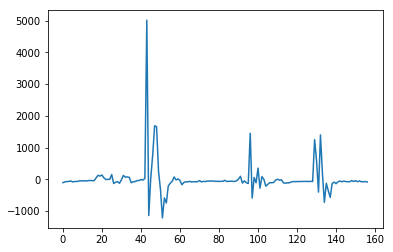

In [530]:
plt.plot(results.resid)

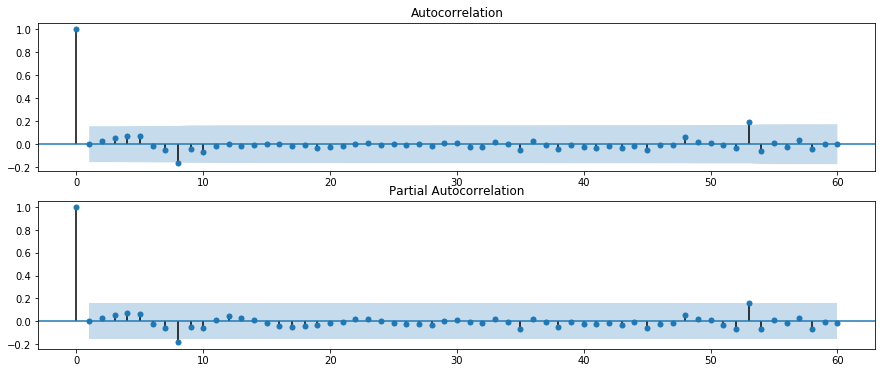

In [531]:
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(results.resid, lags=60, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(results.resid, lags=60, ax=ax2)
plt.show()

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


predicted=104.290434, expected=27.175000
predicted=92.196364, expected=43.465000
predicted=99.761883, expected=17.210000
predicted=98.169322, expected=44.605000
predicted=106.131506, expected=24.135000
predicted=98.865340, expected=18.985000
predicted=91.985817, expected=18.435000
predicted=97.340626, expected=10.605000
Test MSE: 5505.322


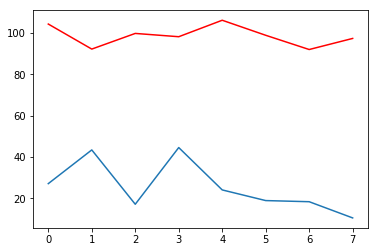

In [532]:
size = int(len(y1) * 0.95)
train, test = y1[0:size], y1[size:len(y1)]
history = [x for x in train]
predictions = list()

for t in range(len(test)):
    model = ARIMA(history, order=(5,0,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
    
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

Twitter doesn't seem very powerful due to it's irregular outliers 

## GE

In [535]:
# find columns 
ge_cols = [col for col in kantar.columns if 'General Electric' in col]
print(ge_cols)

kantar_ge = kantar[ge_cols]

['Ge General Electric Co_B-to-B', 'Ge General Electric Co_Cable TV', 'Ge General Electric Co_Cinema', 'Ge General Electric Co_Hispanic Newsp', 'Ge General Electric Co_Int Display', 'Ge General Electric Co_Int Search', 'Ge General Electric Co_Local Radio', 'Ge General Electric Co_Magazines', 'Ge General Electric Co_Mobile Web', 'Ge General Electric Co_Natl Newsp', 'Ge General Electric Co_Natl Spot Radio', 'Ge General Electric Co_Network TV', 'Ge General Electric Co_Newspapers', 'Ge General Electric Co_Online Video', 'Ge General Electric Co_Outdoor', 'Ge General Electric Co_Spot TV', 'Ge General Electric Co_Sunday Mags']


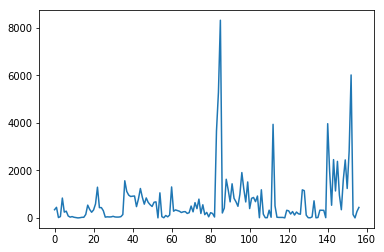

In [536]:
kantar_ge = kantar_ge.fillna(0.0)

kantar_ge['sum'] = kantar_ge.sum(axis=1)

y = kantar_ge['sum']

plt.plot(y)

In [537]:
#ADF Test

#H0: Series is not stationary
#H1: Series is stationary

dftest = adfuller(y, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

print(dfoutput)

Test Statistic                -8.084469e+00
p-value                        1.432146e-12
#Lags Used                     0.000000e+00
Number of Observations Used    1.560000e+02
dtype: float64


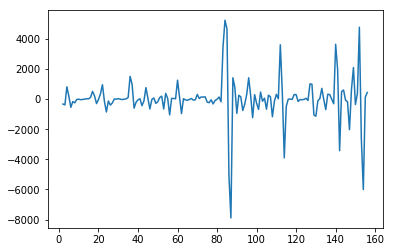

In [540]:
z = y.diff(2)

z.dropna(inplace=True)

plt.plot(z)

In [541]:
dftest = adfuller(z, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

print(dfoutput)

Test Statistic                  -5.090926
p-value                          0.000015
#Lags Used                      11.000000
Number of Observations Used    143.000000
dtype: float64


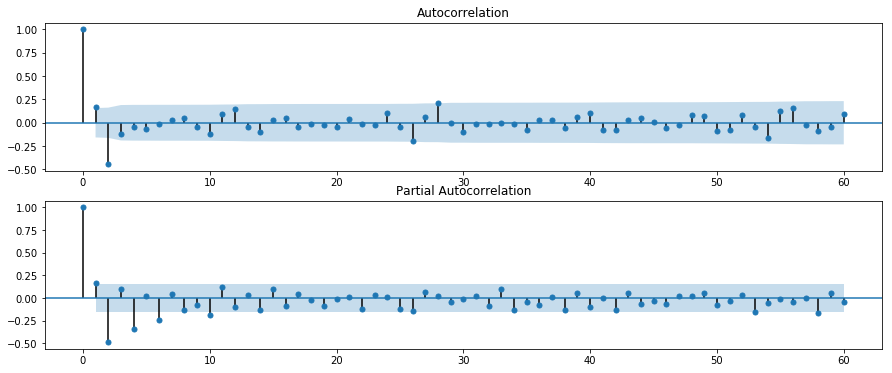

In [542]:
# ACF/PACF

fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(z, lags=60, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(z, lags=60, ax=ax2)
plt.show()

In [550]:
# Convert to array so that it can be read by the ARIMA function.
z1 = z.values
y1 = y.values

# using the series after a difference has been taken and using AR of order 6.
model=sm.tsa.ARIMA(y1,order=(8,2,0))
results=model.fit()
print(results.summary())

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                  155
Model:                 ARIMA(8, 2, 0)   Log Likelihood               -1315.238
Method:                       css-mle   S.D. of innovations           1160.665
Date:                Sat, 07 Apr 2018   AIC                           2650.475
Time:                        18:43:36   BIC                           2680.910
Sample:                             2   HQIC                          2662.837
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.6062     10.542     -0.152      0.879     -22.269      19.057
ar.L1.D2.y    -1.2888      0.078    -16.477      0.000      -1.442      -1.136
ar.L2.D2.y    -1.4320      0.124    -11.551      0.0

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


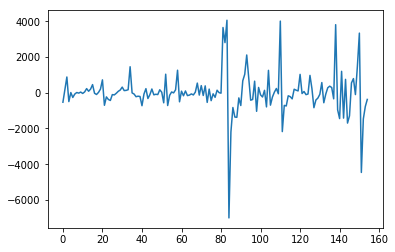

In [551]:
plt.plot(results.resid)

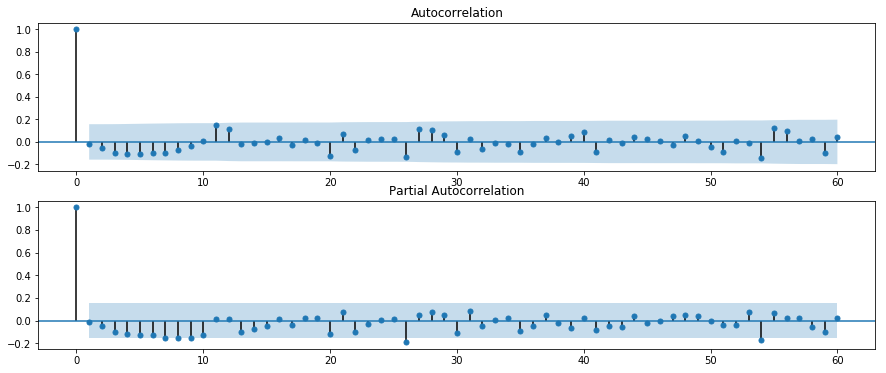

In [552]:
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(results.resid, lags=60, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(results.resid, lags=60, ax=ax2)
plt.show()

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


predicted=1263.448911, expected=2443.912381
predicted=1579.510745, expected=1243.916332
predicted=1405.677873, expected=2814.308924
predicted=2386.786893, expected=6011.907513
predicted=5078.366519, expected=150.685855
predicted=1790.176565, expected=9.443792
predicted=1240.591023, expected=278.572169
predicted=916.721660, expected=448.221005
Test MSE: 5653734.704


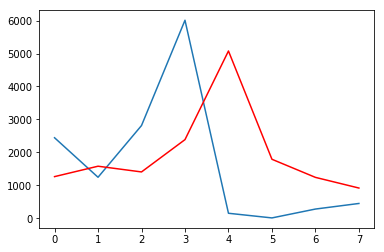

In [553]:
size = int(len(y1) * 0.95)
train, test = y1[0:size], y1[size:len(y1)]
history = [x for x in train]
predictions = list()

for t in range(len(test)):
    model = ARIMA(history, order=(8,2,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
    
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [554]:
ge_preds = results.predict(start=157, end=161, typ='levels')

print(ge_preds)

[ 774.12142788  702.61066955  225.85639782   13.96223394 -686.47521349]


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


In [555]:
sum_ge = pd.DataFrame(y)
ge_preds = pd.DataFrame(ge_preds)

sum_ge = pd.concat([sum_ge['sum'], ge_preds], axis=0)
sum_ge = pd.DataFrame(sum_ge)
sum_ge = sum_ge.set_index(weeks['week'])

sum_ge = sum_ge.resample('D').ffill()

In [556]:
sum_ge.to_csv('sum_ge.csv')

## Alphabet

In [557]:
# find columns 
alph_cols = [col for col in kantar.columns if 'Alphabet' in col]
print(alph_cols)

kantar_alph = kantar[alph_cols]

['Alphabet Inc_B-to-B', 'Alphabet Inc_Cable TV', 'Alphabet Inc_Cinema', 'Alphabet Inc_Hispanic Newsp', 'Alphabet Inc_Int Display', 'Alphabet Inc_Int Search', 'Alphabet Inc_Local Radio', 'Alphabet Inc_Magazines', 'Alphabet Inc_Mobile Web', 'Alphabet Inc_Natl Newsp', 'Alphabet Inc_Natl Spot Radio', 'Alphabet Inc_Network Radio', 'Alphabet Inc_Network TV', 'Alphabet Inc_Newspapers', 'Alphabet Inc_Online Video', 'Alphabet Inc_Outdoor', 'Alphabet Inc_SLN TV', 'Alphabet Inc_Spot TV', 'Alphabet Inc_Sunday Mags', 'Alphabet Inc_Syndication']


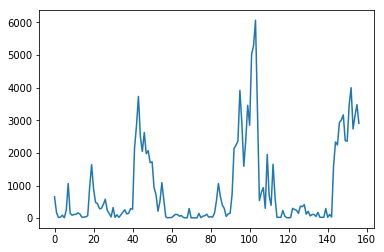

In [558]:
kantar_alph = kantar_alph.fillna(0.0)

kantar_alph['sum'] = kantar_alph.sum(axis=1)

y = kantar_alph['sum']

plt.plot(y)

In [559]:
#ADF Test

#H0: Series is not stationary
#H1: Series is stationary

dftest = adfuller(y, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

print(dfoutput)

Test Statistic                  -2.934969
p-value                          0.041430
#Lags Used                       8.000000
Number of Observations Used    148.000000
dtype: float64


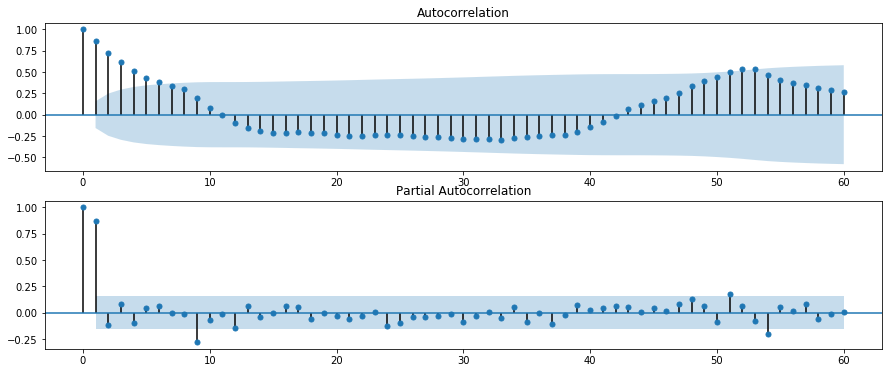

In [560]:
# ACF/PACF

fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(y, lags=60, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(y, lags=60, ax=ax2)
plt.show()

In [561]:
# Convert to array so that it can be read by the ARIMA function.
y1 = y.values

# using the series after a difference has been taken and using AR
model=sm.tsa.ARIMA(y1,order=(5,0,0))
results=model.fit()
print(results.summary())

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  157
Model:                     ARMA(5, 0)   Log Likelihood               -1226.697
Method:                       css-mle   S.D. of innovations            595.475
Date:                Sat, 07 Apr 2018   AIC                           2467.394
Time:                        19:28:15   BIC                           2488.787
Sample:                             0   HQIC                          2476.082
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        966.8953    375.900      2.572      0.011     230.145    1703.646
ar.L1.y        0.9803      0.079     12.389      0.000       0.825       1.135
ar.L2.y       -0.2046      0.111     -1.849      0.0

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


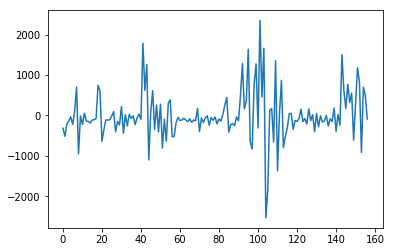

In [562]:
plt.plot(results.resid)

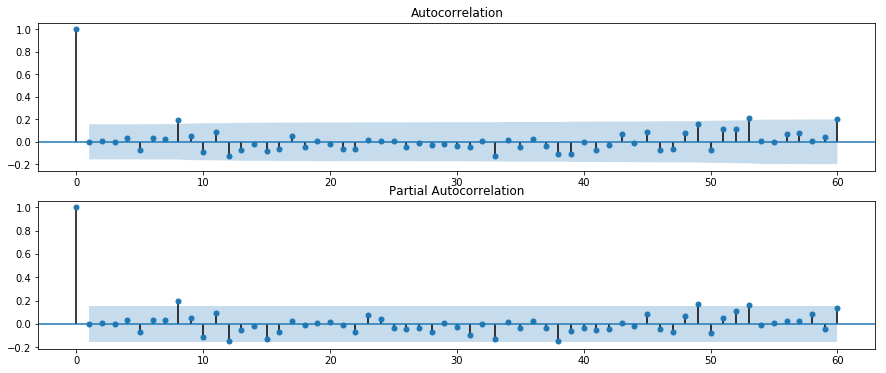

In [563]:
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(results.resid, lags=60, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(results.resid, lags=60, ax=ax2)
plt.show()

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


predicted=2929.556926, expected=2372.542962
predicted=1961.558449, expected=2359.831721
predicted=2181.566303, expected=3463.176317
predicted=3161.297338, expected=3998.720152
predicted=3701.185907, expected=2734.482962
predicted=2381.050487, expected=3142.461303
predicted=2950.847934, expected=3480.267921
predicted=3001.481622, expected=2907.993767
Test MSE: 576996.733


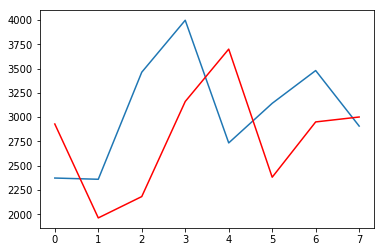

In [564]:
size = int(len(y1) * 0.95)
train, test = y1[0:size], y1[size:len(y1)]
history = [x for x in train]
predictions = list()

for t in range(len(test)):
    model = ARIMA(history, order=(5,0,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
    
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [565]:
alph_preds = results.predict(start=157, end=161)

print(alph_preds)

[2744.06740322 2561.07655086 2277.63041929 2150.03119468 2021.45254356]


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


In [566]:
sum_alph = pd.DataFrame(y)
alph_preds = pd.DataFrame(alph_preds)

sum_alph = pd.concat([sum_alph['sum'], alph_preds], axis=0)
sum_alph = pd.DataFrame(sum_alph)
sum_alph = sum_alph.set_index(weeks['week'])

sum_alph = sum_alph.resample('D').ffill()

In [567]:
sum_alph.to_csv('sum_alph.csv')

## SAP

In [568]:
# find columns 
sap_cols = [col for col in kantar.columns if 'Sap' in col]
print(sap_cols)

kantar_sap = kantar[sap_cols]

['Sap AG_B-to-B', 'Sap AG_Cable TV', 'Sap AG_Int Display', 'Sap AG_Int Search', 'Sap AG_Local Mags', 'Sap AG_Local Radio', 'Sap AG_Magazines', 'Sap AG_Mobile Web', 'Sap AG_Natl Newsp', 'Sap AG_Network Radio', 'Sap AG_Network TV', 'Sap AG_Newspapers', 'Sap AG_Online Video', 'Sap AG_Outdoor', 'Sap AG_Spot TV', 'Sap AG_Syndication']


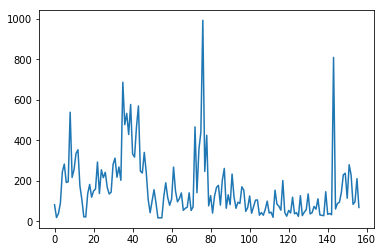

In [569]:
kantar_sap = kantar_sap.fillna(0.0)

kantar_sap['sum'] = kantar_sap.sum(axis=1)

y = kantar_sap['sum']

plt.plot(y)

In [570]:
#ADF Test

#H0: Series is not stationary
#H1: Series is stationary

dftest = adfuller(y, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

print(dfoutput)

Test Statistic                  -3.412733
p-value                          0.010532
#Lags Used                       4.000000
Number of Observations Used    152.000000
dtype: float64


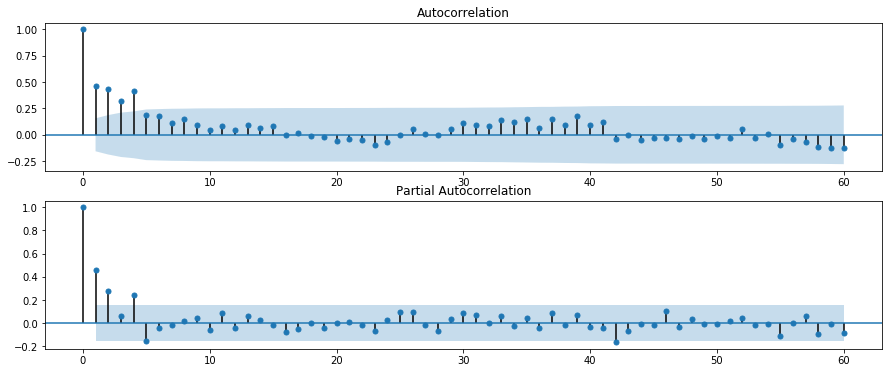

In [571]:
# ACF/PACF

fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(y, lags=60, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(y, lags=60, ax=ax2)
plt.show()

In [572]:
# Convert to array so that it can be read by the ARIMA function.
y1 = y.values

# using the series after a difference has been taken and using AR
model=sm.tsa.ARIMA(y1,order=(4,0,0))
results=model.fit()
print(results.summary())

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  157
Model:                     ARMA(4, 0)   Log Likelihood                -984.165
Method:                       css-mle   S.D. of innovations            127.430
Date:                Sat, 07 Apr 2018   AIC                           1980.331
Time:                        19:44:37   BIC                           1998.668
Sample:                             0   HQIC                          1987.778
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        158.6385     35.501      4.469      0.000      89.057     228.220
ar.L1.y        0.2975      0.077      3.858      0.000       0.146       0.449
ar.L2.y        0.1959      0.081      2.430      0.0

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


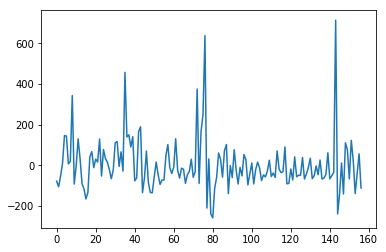

In [573]:
plt.plot(results.resid)

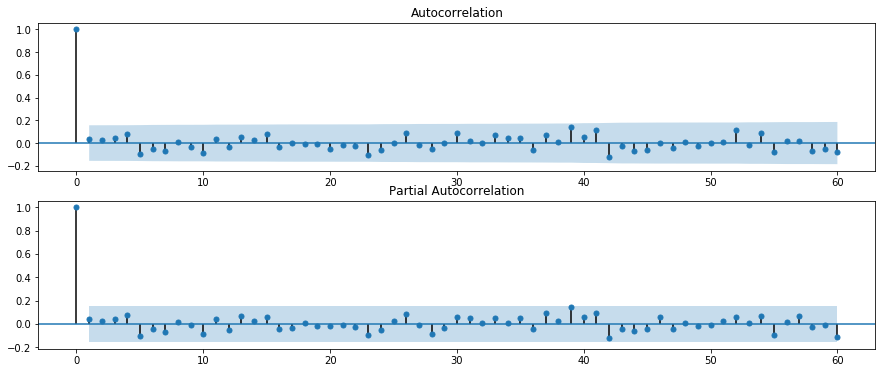

In [574]:
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(results.resid, lags=60, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(results.resid, lags=60, ax=ax2)
plt.show()

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


predicted=161.191716, expected=237.037633
predicted=182.436292, expected=113.465137
predicted=155.054120, expected=279.015382
predicted=202.499286, expected=227.852973
predicted=225.019839, expected=83.384141
predicted=137.812931, expected=96.097518
predicted=153.357912, expected=210.047157
predicted=180.626702, expected=67.850794
Test MSE: 8031.469


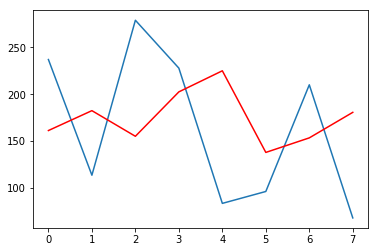

In [575]:
size = int(len(y1) * 0.95)
train, test = y1[0:size], y1[size:len(y1)]
history = [x for x in train]
predictions = list()

for t in range(len(test)):
    model = ARIMA(history, order=(4,0,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
    
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [576]:
sap_preds = results.predict(start=157, end=161)

print(sap_preds)

[124.2938137  115.20089892 152.13884857 126.81009214 140.0934529 ]


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


In [577]:
sum_sap = pd.DataFrame(y)
sap_preds = pd.DataFrame(sap_preds)

sum_sap = pd.concat([sum_sap['sum'], sap_preds], axis=0)
sum_sap = pd.DataFrame(sum_sap)
sum_sap = sum_sap.set_index(weeks['week'])

sum_sap = sum_sap.resample('D').ffill()

In [578]:
sum_sap.to_csv('sum_sap.csv')

# google_trends

Transform to daily data 

In [96]:
google_trends = pd.read_csv('~/Documents/Programming/i-com/2018 Data - Intel Challenge/google_trends.csv')

google_trends['Week'] = pd.to_datetime(google_trends.Week, format='%Y-%m-%d')    
google_trends = google_trends.set_index('Week').resample('D').bfill()

rng = pd.date_range(start = '2015-12-14', end = '2015-12-19', freq = 'D')

values = pd.DataFrame({'twitter artificial intelligence':9, 'sap artificial intelligence':0, 'google artificial intelligence':36,
          'facebook artificial intelligence':5, 'apple artificial intelligence':31, 'amazon artificial intelligence':36,
          'microsoft artificial intelligence':7, 'adobe artificial intelligence':0, 'oracle artificial intelligence':0,
          'intel artificial intelligence':0, 'nvidia artificial intelligence':0, 'ibm artificial intelligence': 7,
          'samsung artificial intelligence':0, 'artificial intelligence':27}, index = rng)

google_trends = pd.concat([values,google_trends], axis=0)

In [97]:
google_trends.shape

(805, 14)

In [98]:
google_trends.head()

,adobe artificial intelligence,amazon artificial intelligence,apple artificial intelligence,artificial intelligence,facebook artificial intelligence,google artificial intelligence,ibm artificial intelligence,intel artificial intelligence,microsoft artificial intelligence,nvidia artificial intelligence,oracle artificial intelligence,samsung artificial intelligence,sap artificial intelligence,twitter artificial intelligence
2015-12-14,0,36,31,27,5,36,7,0,7,0,0,0,0,9
2015-12-15,0,36,31,27,5,36,7,0,7,0,0,0,0,9
2015-12-16,0,36,31,27,5,36,7,0,7,0,0,0,0,9
2015-12-17,0,36,31,27,5,36,7,0,7,0,0,0,0,9
2015-12-18,0,36,31,27,5,36,7,0,7,0,0,0,0,9


# brand_innovate

In [100]:
innovate = pd.read_csv('~/Documents/Programming/i-com/2018 Data - Intel Challenge/brand_innovative.csv')
innovate.iloc[:, 0] = pd.to_datetime(innovate.iloc[:,0])
innovate['date'] = innovate['yr_mm_dd_dtm'].dt.date
innovate.set_index(keys=pd.DatetimeIndex(innovate['date']), drop=True, inplace=True)
innovate.drop(['yr_mm_dd_dtm'], inplace=True, axis=1)

innovate = innovate.resample("D").bfill()
rng = pd.date_range(start = '2016-04-01', end = '2016-04-29', freq='D')
values = pd.DataFrame({' Amazon':175, ' Apple':392, ' Facebook':77,
                      ' Google':231,  ' HP (Hewlett Packard)':98,
                     ' Intel':175, ' Microsoft':189, ' Qualcomm':28,
                     ' Samsung':245}, index=rng)

innovate = pd.concat([values, innovate], axis=0)
innovate.drop(['date'], inplace=True, axis=1)

In [101]:
innovate.shape

(671, 9)

In [102]:
innovate.head()

,Amazon,Apple,Facebook,Google,HP (Hewlett Packard),Intel,Microsoft,Qualcomm,Samsung
2016-04-01,175,392,77,231,98,175,189,28,245
2016-04-02,175,392,77,231,98,175,189,28,245
2016-04-03,175,392,77,231,98,175,189,28,245
2016-04-04,175,392,77,231,98,175,189,28,245
2016-04-05,175,392,77,231,98,175,189,28,245


In [103]:
innovate.isnull().sum()

 Amazon                  0
 Apple                   0
 Facebook                0
 Google                  0
 HP (Hewlett Packard)    0
 Intel                   0
 Microsoft               0
 Qualcomm                0
 Samsung                 0
dtype: int64

# brand_tech_leader

In [104]:
tech = pd.read_csv('~/Documents/Programming/i-com/2018 Data - Intel Challenge/brand_tech_leader.csv')
tech.iloc[:, 0] = pd.to_datetime(tech.iloc[:,0])
tech['date'] = tech['yr_mm_dd_dtm'].dt.date
tech.set_index(keys=pd.DatetimeIndex(tech['date']), drop=True, inplace=True)
tech.drop(['yr_mm_dd_dtm'], inplace=True, axis=1)

tech = tech.resample("D").bfill()

rng = pd.date_range(start = '2016-04-01', end = '2016-04-29', freq='D')
values = pd.DataFrame({' Amazon':140, ' Apple':420, ' Facebook':77,
                      ' Google':238,  ' HP (Hewlett Packard)':126,
                     ' Intel':252, ' Microsoft':252, ' Qualcomm':56,
                     ' Samsung':259}, index=rng)

tech = pd.concat([values, tech], axis=0)
tech.drop(['date'], inplace=True, axis=1)

In [105]:
tech.shape

(671, 9)

In [106]:
tech.head()

,Amazon,Apple,Facebook,Google,HP (Hewlett Packard),Intel,Microsoft,Qualcomm,Samsung
2016-04-01,140,420,77,238,126,252,252,56,259
2016-04-02,140,420,77,238,126,252,252,56,259
2016-04-03,140,420,77,238,126,252,252,56,259
2016-04-04,140,420,77,238,126,252,252,56,259
2016-04-05,140,420,77,238,126,252,252,56,259


In [108]:
tech.isnull().sum()

 Amazon                  0
 Apple                   0
 Facebook                0
 Google                  0
 HP (Hewlett Packard)    0
 Intel                   0
 Microsoft               0
 Qualcomm                0
 Samsung                 0
dtype: int64

# comments

In [5]:
allFiles = glob.glob("comments/intel_*.csv")

concats = []

for file in allFiles:
    comments = pd.read_csv(file)
    concats.append(comments)

comments_target = pd.concat(concats)

comments_target.drop(["Unnamed: 0"], inplace=True, axis=1)
comments_target.date = pd.to_datetime(comments_target.date)
comments_target['day'] = comments_target['date'].dt.date
comments = comments_target.groupby('day').size()

2017 tweet hashtag analysis

In [10]:
comments_2017 = comments_target[comments_target.date.dt.year == 2017]

In [11]:
twitter_rows = [index for index, row in enumerate(comments_2017['url']) if 'twitter' in row]

In [15]:
tweets = comments_2017.loc[twitter_rows, :] 

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [18]:
tweets_dec = tweets[tweets.date.dt.month == 12]

In [60]:
hashtags = tweets_dec.snippet.str.findall(r'#.*?(?=\s|$)')

In [37]:
hashtags = hashtags.values.reshape(-1,).tolist()

In [42]:
from itertools import chain

h1 = list(chain.from_iterable(hashtags))

In [47]:
h1 = [x.lower() for x in h1]

Tweet sentiment analysis

In [ ]:
def get_tweet_sentiment(self, tweet):
        '''
        Utility function to classify sentiment of passed tweet
        using textblob's sentiment method
        '''
    # create TextBlob object of passed tweet text
    analysis = TextBlob(self.clean_tweet(tweet))
    # set sentiment
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity == 0:
        return 'neutral'
    else:
        return 'negative'

# page_events

In [143]:
view1 = pd.read_csv("~/Documents/Programming/i-com/2018 Data - Intel Challenge/page_events/page_events1_intel.csv")
view2 = pd.read_csv("~/Documents/Programming/i-com/2018 Data - Intel Challenge/page_events/page_events2_intel.csv")

view = pd.concat([view1,view2])

view.idate = pd.to_datetime(view.idate)
views =  view.groupby('idate').size()

In [140]:
view.isnull().sum()

browser_family     191962
geo_city          1276353
geo_country            12
keyword                 0
category                0
os_family          191962
page_url                0
domain                  0
geo_region          65443
user_agent         191962
user_domain       1032984
user_id             13564
ip_address          52693
bid_time                0
idate                   0
dtype: int64

In [581]:
view.head()

,browser_family,geo_city,geo_country,keyword,category,os_family,page_url,domain,geo_region,user_agent,user_domain,user_id,ip_address,bid_time,idate
0,IE,Saint Peters,USA,multi core embed,DEV_IOT,Windows,https://www.researchgate.net/publication/29052...,researchgate.net,USA/MO,Mozilla/5.0 (Windows NT 10.0; WOW64; Trident/7...,eds.com,bito.AAB8QE6y_p8AACX2aelRFA,134.244.29.2,2017-07-31T15:41:39.000Z,2017-07-31
1,IE,Saint Peters,USA,multi core embed,DEV_IOT,Windows,https://www.researchgate.net/publication/29052...,researchgate.net,USA/MO,Mozilla/5.0 (Windows NT 10.0; WOW64; Trident/7...,eds.com,bito.AAB8QE6y_p8AACX2aelRFA,134.244.29.2,2017-07-31T15:41:39.000Z,2017-07-31
2,IE,Saint Peters,USA,multi core embed,DEV_IOT,Windows,https://www.researchgate.net/publication/29052...,researchgate.net,USA/MO,Mozilla/5.0 (Windows NT 10.0; WOW64; Trident/7...,eds.com,bito.AAB8QE6y_p8AACX2aelRFA,134.244.29.2,2017-07-31T15:42:05.000Z,2017-07-31
3,IE,Saint Peters,USA,multi core embed,DEV_IOT,Windows,https://www.researchgate.net/publication/29052...,researchgate.net,USA/MO,Mozilla/5.0 (Windows NT 10.0; WOW64; Trident/7...,eds.com,bito.AAB8QE6y_p8AACX2aelRFA,134.244.29.2,2017-07-31T15:42:05.000Z,2017-07-31
4,Safari,Madison,USA,spark stream,BIG_DATA_REAL_TIME,Mac OS X,https://mvnrepository.com/artifact/org.apache....,mvnrepository.com,USA/WI,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_6...,hoyosconsulting.com,bito.AAC3ak6yc3wAAC2oxTVXNw,162.248.233.46,2017-06-15T21:37:54.000Z,2017-06-15


# join data for explanatory variables

In [155]:
features = pd.merge(google_trends, innovate, left_index = True, right_index = True)
feats = pd.merge(features, tech, left_index = True, right_index = True)

In [157]:
feats.shape

(671, 32)

In [170]:
feats

,adobe artificial intelligence,amazon artificial intelligence,apple artificial intelligence,artificial intelligence,facebook artificial intelligence,google artificial intelligence,ibm artificial intelligence,intel artificial intelligence,microsoft artificial intelligence,nvidia artificial intelligence,...,Samsung_x,Amazon_y,Apple_y,Facebook_y,Google_y,HP (Hewlett Packard)_y,Intel_y,Microsoft_y,Qualcomm_y,Samsung_y
2016-04-01,0,20,29,39,4,38,18,18,30,12,...,245,140,420,77,238,126,252,252,56,259
2016-04-02,0,20,29,39,4,38,18,18,30,12,...,245,140,420,77,238,126,252,252,56,259
2016-04-03,0,20,29,39,4,38,18,18,30,12,...,245,140,420,77,238,126,252,252,56,259
2016-04-04,0,29,0,40,5,41,31,0,20,0,...,245,140,420,77,238,126,252,252,56,259
2016-04-05,0,29,0,40,5,41,31,0,20,0,...,245,140,420,77,238,126,252,252,56,259
2016-04-06,0,29,0,40,5,41,31,0,20,0,...,245,140,420,77,238,126,252,252,56,259
2016-04-07,0,29,0,40,5,41,31,0,20,0,...,245,140,420,77,238,126,252,252,56,259
2016-04-08,0,29,0,40,5,41,31,0,20,0,...,245,140,420,77,238,126,252,252,56,259
2016-04-09,0,29,0,40,5,41,31,0,20,0,...,245,140,420,77,238,126,252,252,56,259
2016-04-10,0,29,0,40,5,41,31,0,20,0,...,245,140,420,77,238,126,252,252,56,259


In [171]:
X_comments = feats['2016-06-01':'2017-12-31']

In [172]:
X_views = feats['2017-03-13':'2017-12-31']

# baseline

In [159]:
#Build our model method
lm = LinearRegression()

#Build our cross validation method
kfolds = KFold(n_splits=10, shuffle=True, random_state=23)

In [160]:
#build our model scoring function
def cv_rmse(model, X, y):
   rmse = np.sqrt(-cross_val_score(model, X, y, 
                                  scoring="neg_mean_squared_error", 
                                  cv = kfolds))
   return(rmse)

In [161]:
#ridge alpha selector
from sklearn.linear_model import RidgeCV
def ridge_selector(k, X, y):
   ridge_model = make_pipeline(RobustScaler(),
                               RidgeCV(alphas = [k],
                                       cv=kfolds)).fit(X, y)
   
   ridge_rmse = cv_rmse(ridge_model, X, y).mean()
   return(ridge_rmse)

BASELINE CODE

In [162]:
r_alphas = [0.00000001, .0001, .0003, .0005, .0007, .0009, 
         .01, 0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 20, 30, 50, 60, 70, 80]

ridge_scores = []
for alpha in r_alphas:
   score = ridge_selector(alpha, X_comments, comments)
   ridge_scores.append(score)
   
plt.plot(r_alphas, ridge_scores, label='Ridge')
plt.legend('center')
plt.xlabel('alpha')
plt.ylabel('score')

ridge_score_table = pd.DataFrame(ridge_scores, r_alphas, columns=['RMSE'])

#ridge_score_table

NameError: name 'X_comments' is not defined